# Detection of Stomach or Intestine in Medial Images Using ResNet50V2

In [29]:
#!pip install tensorflow
#import os
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score, roc_curve
from keras.models import load_model

# Constants and Hyperparameters

In [30]:
# Define hyperparameters and constants
MEAN = 0.136
STD = 0.178
IM_SIZE = 288
BATCH_SIZE=32

# Evaluation Functions

In [31]:
def find_roc_threshold_tpr(y, y_pred, value_target):
    """
    This function calculates the threshold and false positive rate corresponding to a true positive rate of value_target (from 0 to 1).
       
    y                     # Real labels
    y_pred                # Predicted labels
    value_target          # False positive rate value
    
    Returns:
    
    threshold             # Threshold value
    true_positive_rate   # True positive rate value
    """

    fpr, tpr, thr = roc_curve(y, y_pred)

    old_diff = 100000000
    for index, value in enumerate(tpr):
        new_diff = abs(value_target - value)
        if new_diff < old_diff:
            false_pos_rate = fpr[index]
            threshold = thr[index]
            old_diff = new_diff

    return threshold, false_pos_rate

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges,
                          figsize=(10,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    # Confusion matrix
    #cm = confusion_matrix(test_labels, rf_predictions)
    #plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
    #                      title = 'Health Confusion Matrix')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    # Plot the confusion matrix
    plt.figure(figsize = figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    #plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Binary Classification Model

In [32]:
# Function for custom normalization
def custom_normalization(image):  
    image = image / 255.0
    image = (image - MEAN) / STD
    return image

# Image preprocessing
test_datagen = ImageDataGenerator(
    preprocessing_function = custom_normalization)

# Define the test set with 2d format
test_generator_2d = test_datagen.flow_from_directory(
    'dataset_UWM_GI_Tract_classification_rgb/test',
    target_size=(IM_SIZE, IM_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Define the test set with 2.5d format
test_generator_2p5d = test_datagen.flow_from_directory(
    'dataset_UWM_GI_Tract_classification_rgb_2p5d/test',
    target_size=(IM_SIZE, IM_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 5040 images belonging to 2 classes.
Found 5040 images belonging to 2 classes.


In [33]:
# Load models
model_1 = load_model('resnet50v2_nn256_lr0001_relu_batch32_epoch20.keras')
model_2 = load_model('resnet50v2_nn256_lr0001_relu_batch32_epoch30.keras')
model_3 = load_model('resnet50v2_nn256_lr0001_relu_batch32_epoch30_v2.keras')
model_4 = load_model('resnet50v2_nn256_lr0001_relu_batch32_epoch30_v2_2p5d.keras')

# Evaluation

In [34]:
# Make predictions
y_pred_1 = model_1.predict(test_generator_2d).reshape(-1)
y_pred_2 = model_2.predict(test_generator_2d).reshape(-1)
y_pred_3 = model_3.predict(test_generator_2d).reshape(-1)
y_pred_4 = model_4.predict(test_generator_2p5d).reshape(-1)

C:\Users\ssre_\.venv_common\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


158/158 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step


In [35]:
y_test = test_generator_2d.labels

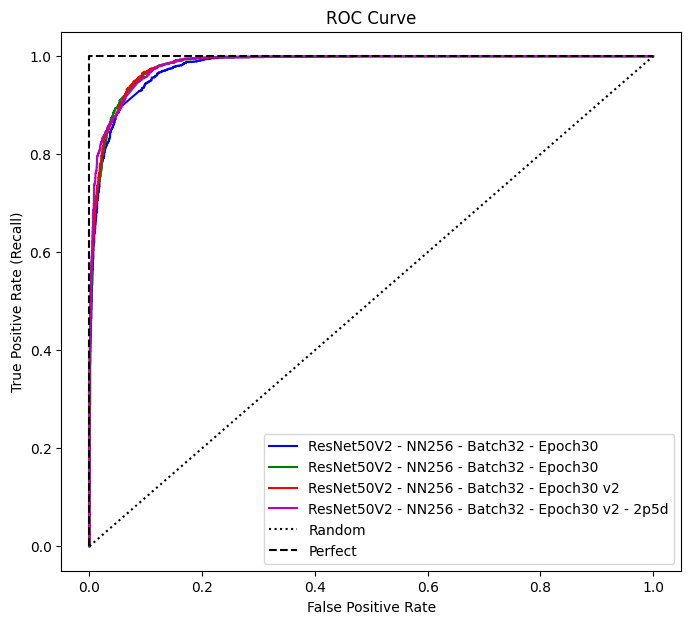

In [36]:
# Plot ROC curves
fpr1, tpr1, thr_roc1 = roc_curve(y_test, y_pred_1)
fpr2, tpr2, thr_roc2 = roc_curve(y_test, y_pred_2)
fpr3, tpr3, thr_roc3 = roc_curve(y_test, y_pred_3)
fpr4, tpr4, thr_roc4 = roc_curve(y_test, y_pred_4)

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot()
plt.plot(fpr1, tpr1, 'b-', label = 'ResNet50V2 - NN256 - Batch32 - Epoch30')
plt.plot(fpr2, tpr2, 'g-', label = 'ResNet50V2 - NN256 - Batch32 - Epoch30')
plt.plot(fpr3, tpr3, 'r-', label = 'ResNet50V2 - NN256 - Batch32 - Epoch30 v2')
plt.plot(fpr4, tpr4, 'm-', label = 'ResNet50V2 - NN256 - Batch32 - Epoch30 v2 - 2p5d')

plt.plot([0,1],[0,1],'k:', label = 'Random')
plt.plot([0,0,1,1,],[0,1,1,1],'k--', label='Perfect')
plt.legend(fontsize=10)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.show()

In [43]:
# Compute the threshold to achieve a 99% recall
recall = 0.995
thr, fpr = find_roc_threshold_tpr(y_test, y_pred_4, recall)
print(f"Threshold for {round(100*recall, 2)}% recall: {thr}")
print(f"False Positive Rate: {round(100*fpr, 2)}%")

Threshold for 99.5% recall: 0.1586085855960846
False Positive Rate: 17.19%


Normalized confusion matrix


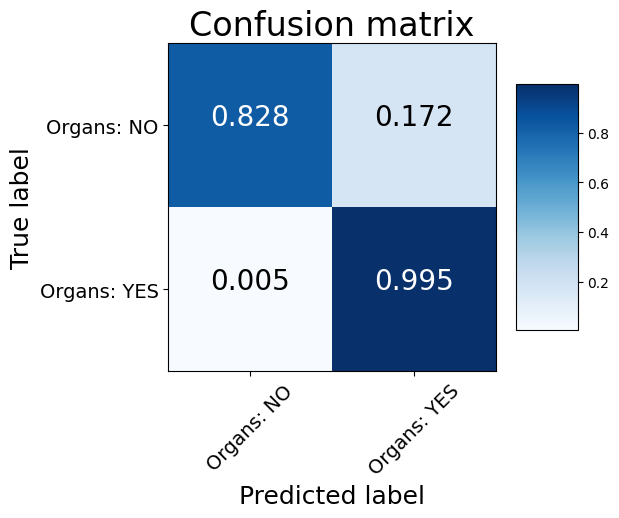

In [44]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_4 >= thr)
plot_confusion_matrix(cm,
                      ['Organs: NO', 'Organs: YES'],
                      normalize=True,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues,
                      figsize=(6,6))

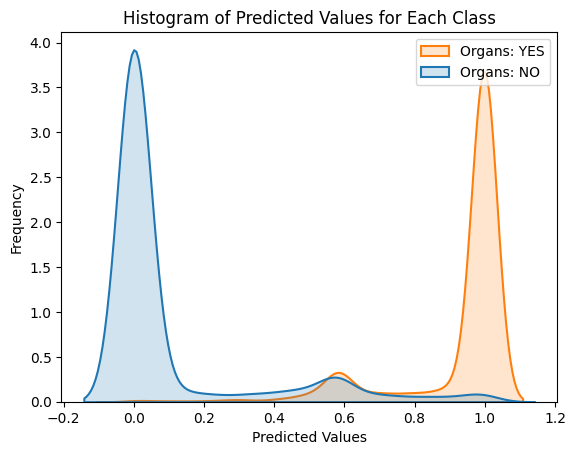

In [45]:
import seaborn as sns

# Create a DataFrame with predicted values and true labels
df = pd.DataFrame({'Predicted': list(y_pred_4), 'Real': list(y_test)})
df.Predicted = df.Predicted.astype(float)
df.Real = df.Real.astype(int)

## Plot histograms
sns.kdeplot(data=df, x='Predicted', hue='Real', fill=True, alpha=0.2, linewidth=1.5)
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Values for Each Class')
plt.legend(labels=['Organs: YES', 'Organs: NO'])
plt.show()

As observed in the figure, the CNN model is able to clearly separate the two classes.